In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import random
from matplotlib import image
from sklearn.model_selection import train_test_split
import pickle
from datetime import datetime
from sklearn.utils import class_weight

In [2]:
import pandas as pd
from PIL import Image
import seaborn as sns
from ipywidgets import widgets
from pathlib import Path
from IPython.display import display
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout

In [312]:
def get_classes(dir_path):
    return os.listdir(dir_path)

def data_analysis_histogram(dir_path, classes, verbose = 1):
    class_dist = []
    for c in classes:
        class_path = os.path.join(dir_path,c)
        class_dist.append(len(os.listdir(class_path)))
    
    if verbose > 0:
        plt.figure(figsize=(16, 8))
        plt.title("Class distribution")
        plt.barh(classes, class_dist)
        for index, value in enumerate(class_dist):
            plt.text(value, index,str(value))
        plt.show()
    return class_dist

def data_analysis_image_size(dir_path, classes, verbose = 1, seed = 42):
    random.seed(seed)
    random_class_path = os.path.join(dir_path,random.choice(classes))
    random_img_name = random.choice(os.listdir(random_class_path))
    random_img_path = os.path.join(random_class_path,random_img_name)
    img = image.imread(random_img_path)
    if verbose > 0:
        plt.figure(figsize=(16, 8))
        plt.title("%s - Height: %d px x Length: %d px" % (random_img_path,img.shape[0],img.shape[1]))
        plt.imshow(img)
    
    return (img.shape[0],img.shape[1],1)

def analyse_dataset(dir_path, verbose = 1, seed = 42):
    classes = get_classes(dir_path)
    class_dist = data_analysis_histogram(dir_path,classes, verbose)
    input_shape = data_analysis_image_size(dir_path,classes, verbose, seed)
    return classes, input_shape, class_dist


In [4]:
def load_dataset(dir_path, percentage = 1, verbose = 1):
    classes = get_classes(dir_path)
    img_array = []
    class_array = []
    for c in classes:
        class_path = os.path.join(dir_path,c)
        imgs_name = os.listdir(class_path)

        if percentage < 1:
            imgs_name = random.sample(imgs_name, k = int(len(imgs_name)*percentage))

        for i in imgs_name:
            img_array.append(image.imread(os.path.join(class_path,i)))
            class_array.append(c)
    if verbose > 0:
        print("Loaded %d images" % len(img_array))
        
    return np.array(img_array), np.array(class_array)

In [5]:
def split_dataset(x, y, val_size = 0.2, verbose = 1, seed = 42):
    x_train, x_val, y_train, y_val = train_test_split(x,  y, test_size=val_size, random_state=seed)
    if verbose > 0:
        print("Train size: %d\nValidation size: %d" % (len(x_train), len(x_val)))
    return x_train, x_val, y_train, y_val


In [295]:
def prepare_dataset_channel_position(x, input_shape):
    img_lin,img_col,n_channels = input_shape
    if keras.backend.image_data_format() == 'channels_first':
        x = x.reshape(x.shape[0], n_channels, img_lin, img_col)
        input_shape = (n_channels, img_lin, img_col)
    else:
        x = x.reshape(x.shape[0], img_lin, img_col, n_channels)
        input_shape = (img_lin, img_col, n_channels)
    return x, input_shape

def prepare_dataset_input(x, input_shape):
    x_scaled = x.astype('float32') / 255.0
    return prepare_dataset_channel_position(x_scaled, input_shape)

def prepare_dataset_output(y, classes):
    class_map = {x: i for i,x in enumerate(classes)}
    y_code = [class_map[word] for word in y]
    y_categorical = keras.utils.to_categorical(y_code, len(classes))
    inv_class_map = {v: k for k, v in class_map.items()}
    return y_categorical, inv_class_map

def prepare_dataset(x , y , classes, input_shape):
    x_scaled, input_shape = prepare_dataset_input(x, input_shape)
    y_categorical, inv_class_map = prepare_dataset_output(y, classes)
    return x_scaled , y_categorical, inv_class_map, input_shape

In [308]:
def evaluate_model_by_class(model, x, y, verbose = 1):
    def separate_by_class(x, y):
        n_classes = y.shape[1]
        x_classified = [[] for _ in range(n_classes)]
        y_classified = [[] for _ in range(n_classes)]
        
        for i,img in enumerate(y):
            index = np.where(img==1)[0][0]
            x_classified[index].append(x[i])
            y_classified[index].append(y[i])

        for i in range(n_classes):
            x_classified[i] = np.array(x_classified[i])
            y_classified[i] = np.array(y_classified[i])
            
        return np.array(x_classified,dtype=object), np.array(y_classified,dtype=object)

    x_by_class, y_by_class = separate_by_class(x,y)
    
    score_by_class = []
    for i,(x,y) in enumerate(zip(x_by_class,y_by_class)):
        score = model.evaluate(x, y, verbose = verbose)
        score_by_class.append(score)

    return score_by_class
    
def evaluate_model(model, x, y, inv_class_map, verbose = 1):
    score = model.evaluate(x, y, verbose = verbose)
    score_by_class = evaluate_model_by_class(model, x, y, verbose)

    if verbose > 0:
        print()
        print("Global loss: %.4f" % (score))
        for i, score in enumerate(score_by_class):
            print("Class %s loss: %.4f" % (inv_class_map[i], score))

    return score, score_by_class

In [309]:
def plot_loss_history(history,verbose):
    if verbose > 0:
        plt.figure(figsize=(16, 8))
        plt.plot(history['loss'], label="Loss")
        plt.show()

In [8]:
def save_result(model, history, dir_path = 'results'):
    results_directory = os.path.join(dir_path)

    if not os.path.exists(results_directory):
        os.makedirs(results_directory)
    
    now = datetime.now()
    now_str = now.strftime("%Y-%m-%d-%H-%M-%S-%f")

    result_directory = os.path.join(results_directory,now_str)

    if not os.path.exists(result_directory):
        os.makedirs(result_directory)
    else:
        raise ValueError("File already exists.")
    
    model_path = os.path.join(result_directory,'model')
    model.save(model_path)

    evaluation_path = os.path.join(result_directory,'evaluation')

    evaluation = {
            'epochs': history.params['epochs'],
            'history': history.history
    }

    with open(evaluation_path, 'wb') as f:
        pickle.dump(evaluation, f)
    
    print("Saved!")

In [9]:
def load_result(foldername, dir_path = 'results'):
    result_directory = os.path.join(dir_path,foldername)
    if not os.path.exists(result_directory):
        raise ValueError("Folder not found.")
    
    model_path = os.path.join(result_directory,'model')
    model = keras.models.load_model(model_path)

    evaluation_path = os.path.join(result_directory,'evaluation')
    evaluation = pickle.load(open(evaluation_path, "rb"))
    
    return model, evaluation


###############################################################################################################################################################################################

In [11]:
def run_cnn(input_shape, classes, verbose = 1):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1),  padding='same', activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(len(classes), activation='softmax'))

    if verbose > 0:
        model.summary()

    model.compile(loss='categorical_crossentropy',
              optimizer='adam')

    history = model.fit(x_train_prepared, y_train_prepared,
                    batch_size=128,
                    epochs=100, verbose=verbose)

    return model, history

###############################################################################################################################################################################################

In [18]:
model, evaluation = load_result('2021-11-03-03-42-59-498819')
history = evaluation['history']

###############################################################################################################################################################################################

In [14]:

# Parameters
dir_path = '../Alzheimer_s Dataset/train'
verbose_loading = 0
verbose_training = 1
verbose_evaluating = 1
dataset_percentage = 1
validation_percentage = 0.2
seed = 42

In [314]:

# Loading and preparing training dataset
classes, input_shape, class_dist = analyse_dataset(dir_path, verbose_loading, seed)
x, y = load_dataset(dir_path, dataset_percentage , verbose_loading)
x_train, x_val, y_train, y_val = split_dataset(x, y, validation_percentage, verbose_loading, seed)
x_train_prepared , y_train_prepared, inv_class_map, input_shape = prepare_dataset(x_train , y_train , classes, input_shape)
x_val_prepared , y_val_prepared, _, _ = prepare_dataset(x_val , y_val , classes, input_shape)

In [201]:
# Executing
model, history = run_cnn(input_shape, classes, verbose_training)
save_result(model, history)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 208, 176, 64)      640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 104, 88, 64)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 104, 88, 64)       36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 52, 44, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 52, 44, 64)        36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 146432)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                

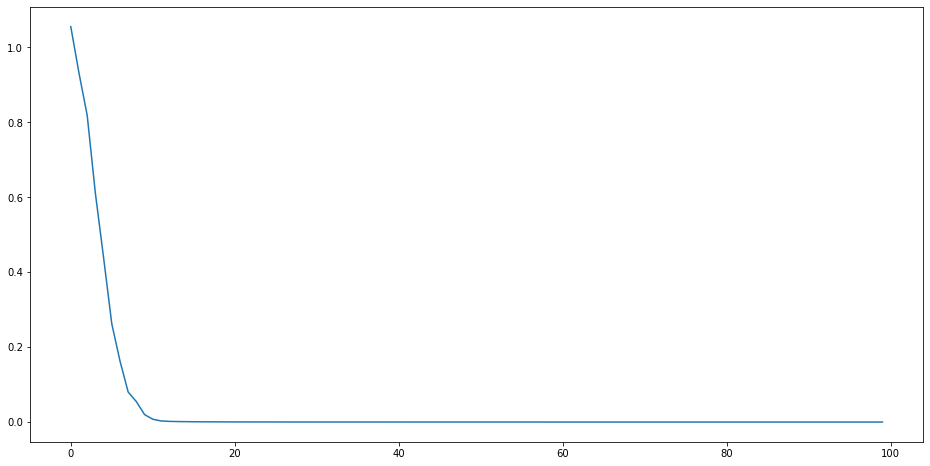


Training
46/46 [==============================] - 8s 178ms/step - loss: 2.2172e-06

Global loss: 0.0000
Class MildDemented loss: 0.0000
Class ModerateDemented loss: 0.0000
Class NonDemented loss: 0.0000
Class VeryMildDemented loss: 0.0000

Validation
11/11 [==============================] - 2s 193ms/step - loss: 0.0072

Global loss: 0.0502
Class MildDemented loss: 0.2566
Class ModerateDemented loss: 0.1954
Class NonDemented loss: 0.0099
Class VeryMildDemented loss: 0.0072


In [311]:
# Evaluating CNN
plot_loss_history(history,verbose_evaluating)
print("\nTraining")
train_score, train_score_by_class = evaluate_model(model, x_train_prepared, y_train_prepared, inv_class_map, verbose_evaluating)
print("\nValidation")
val_score, val_score_by_class = evaluate_model(model, x_val_prepared, y_val_prepared, inv_class_map, verbose_evaluating)